In [1]:
"""Fourinarow reinforcement learning environment."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import dm_env
from dm_env import specs
import numpy as np
import ctypes
import matplotlib.pyplot as plt
from matplotlib import patches,colors

In [2]:
mydll = ctypes.cdll.LoadLibrary('../fourinarow.dll')
#This loads the C++ model code
mydll.makemove.argtypes = (ctypes.c_int, ctypes.c_char_p, ctypes.c_char_p, ctypes.c_bool, ctypes.POINTER(ctypes.c_double))
#The arguments to the C++ makemove function are
# a seed (int)
# the configuration of the black pieces (string of 0's and 1's)
# the configuration of the white pieces (string of 0's and 1's)
# the player whose move it is (boolean, False is Black, True is White)
# a list of parameters

In [3]:
all_params = np.loadtxt('../../Parameters.txt')
#parameters for the cognitive model, derived from human play.
#this list contains 200 parameter vectors, which reflect variability in human strategies

In [4]:
fourinarows = np.array([[ 0,  9, 18, 27], #hard-coding all ways in which four-in-a-row can appear
                       [ 1, 10, 19, 28],
                       [ 2, 11, 20, 29],
                       [ 3, 12, 21, 30],
                       [ 4, 13, 22, 31],
                       [ 5, 14, 23, 32],
                       [ 6, 15, 24, 33],
                       [ 7, 16, 25, 34],
                       [ 8, 17, 26, 35],
                       [ 0, 10, 20, 30],
                       [ 1, 11, 21, 31],
                       [ 2, 12, 22, 32],
                       [ 3, 13, 23, 33],
                       [ 4, 14, 24, 34],
                       [ 5, 15, 25, 35],
                       [ 3, 11, 19, 27],
                       [ 4, 12, 20, 28],
                       [ 5, 13, 21, 29],
                       [ 6, 14, 22, 30],
                       [ 7, 15, 23, 31],
                       [ 8, 16, 24, 32],
                       [ 0,  1,  2,  3],
                       [ 1,  2,  3,  4],
                       [ 2,  3,  4,  5],
                       [ 3,  4,  5,  6],
                       [ 4,  5,  6,  7],
                       [ 5,  6,  7,  8],
                       [ 9, 10, 11, 12],
                       [10, 11, 12, 13],
                       [11, 12, 13, 14],
                       [12, 13, 14, 15],
                       [13, 14, 15, 16],
                       [14, 15, 16, 17],
                       [18, 19, 20, 21],
                       [19, 20, 21, 22],
                       [20, 21, 22, 23],
                       [21, 22, 23, 24],
                       [22, 23, 24, 25],
                       [23, 24, 25, 26],
                       [27, 28, 29, 30],
                       [28, 29, 30, 31],
                       [29, 30, 31, 32],
                       [30, 31, 32, 33],
                       [31, 32, 33, 34],
                       [32, 33, 34, 35]],dtype=int)

def check_fourinarow(pieces):
    """
    checks if the player controlling pieces made 4-in-a-row on their last move
    """
    return np.any(np.sum(pieces[fourinarows],axis=1)==4)

def check_draw(bp,wp):
    """
    checks if the game is drawn
    """
    return np.sum(bp) + np.sum(wp)==36
    

In [5]:
def makemove(seed,bp,wp,color,params):
    """
    Python wrapper for the model code, makes a move in a given board position following the cognitive model outlined in 
    van Opheusden, 2017 (https://tinyurl.com/s74q29z)
    """
    #unoccupied_squares = np.nonzero(np.logical_and([bp==0,wp==0]))
    #return np.random.choice(unoccupied_squares)
    array_type = ctypes.c_double * len(params)
    m = mydll.makemove(seed,"".join(bp.astype(int).astype(str)).encode('utf-8'),
                       "".join(wp.astype(int).astype(str)).encode('utf-8'),color,array_type(*params))
    #with open('c++_output.txt', 'r') as fin:
    #    print(fin.read())
    return m

In [6]:
cm = colors.LinearSegmentedColormap.from_list('gray_gold_map', [colors.to_rgb('darkgray'), 
                                                                colors.to_rgb('gold')], N=100)

def show_board(black_pieces,white_pieces):
    """
    Code to display a board as a matplotlib figure
    """
    fig = plt.figure()
    ax = fig.add_subplot(111,aspect='equal')
    ax.vlines(np.arange(-0.5,9.5,1),-0.5,3.5)
    ax.hlines(np.arange(-0.5,4.5,1),-0.5,8.5)
    for p in black_pieces:
        circ = patches.Circle((p%9,p//9),0.33,color="black",fill=True)
        circ = ax.add_patch(circ)
    for p in white_pieces:
        circ = patches.Circle((p%9,p//9),0.33,color="white",fill=True)
        circ = ax.add_patch(circ)
    plt.imshow(np.zeros(shape=[4,9]), cmap=cm, 
               interpolation='nearest',origin='bottom',vmin=0,vmax=0.2)
    ax.axis('off')
    fig.tight_layout()
    plt.show()

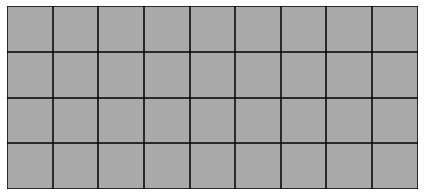

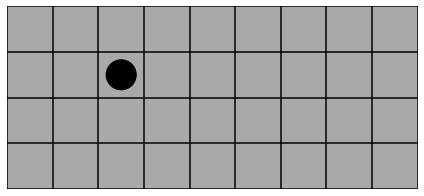

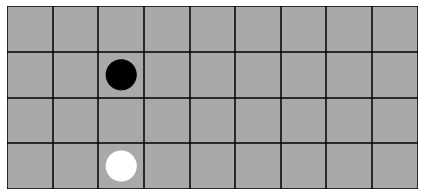

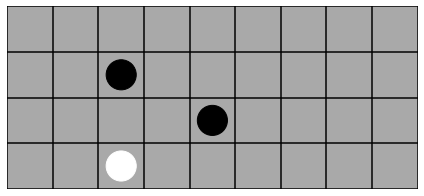

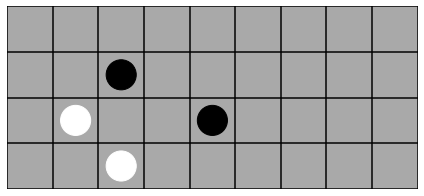

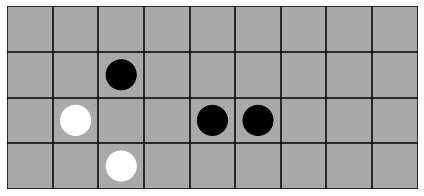

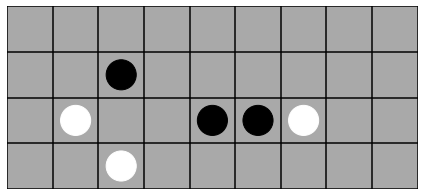

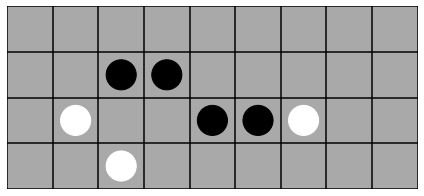

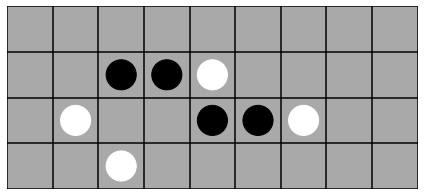

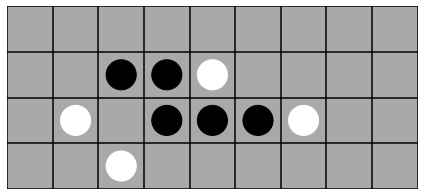

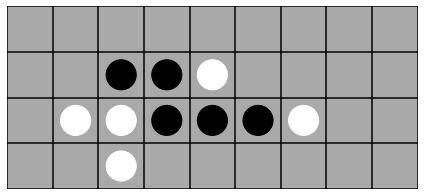

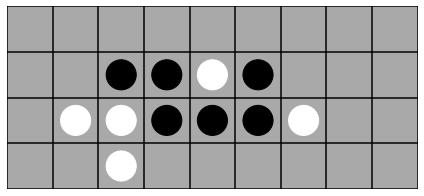

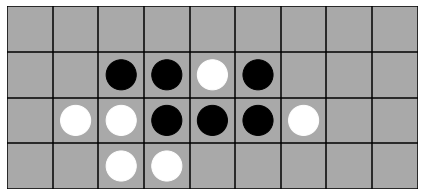

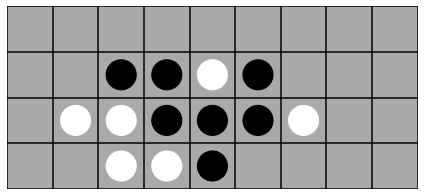

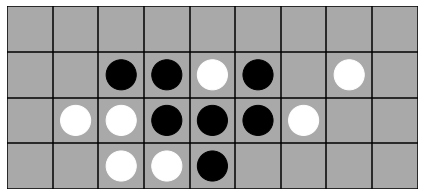

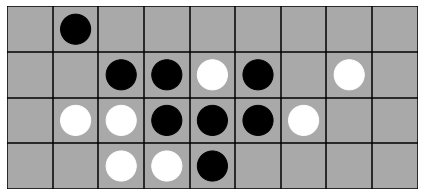

In [7]:
#this cell simulates a game between the model (with random parameters each move) and itself

color = False #Black
bp= np.zeros(36)
wp= np.zeros(36)

for _ in range(36):
    m = makemove(np.random.randint(2**31),bp,wp,color,list(all_params[np.random.randint(200),:]))
    #print(bp,wp,m)
    show_board(np.nonzero(bp)[0],np.nonzero(wp)[0])
    if color:
        wp[m] = 1
    else:
        bp[m] = 1
    if check_draw(bp,wp) or check_fourinarow(wp if color else bp):
        show_board(np.nonzero(bp)[0],np.nonzero(wp)[0])
        break
    color = not color

In [8]:
class Fourinarow(dm_env.Environment):
    """
    DM environment for playing fourinarow against a constant opponent
    """

    def __init__(self, seed=1):
        self._rng = np.random.RandomState(seed)
        self._reset_next_step = True
        self.reset()
        
    def reset(self):
        """Returns the first `TimeStep` of a new episode."""
        self._reset_next_step = False
        self._bp = np.zeros(36, dtype=np.float32) #Black pieces
        self._wp = np.zeros(36, dtype=np.float32) #White pieces
        return dm_env.restart(self._observation())

    def step(self, action):
        """Updates the environment according to the action."""
        if self._reset_next_step:
            return self.reset()

        agent_move = action

        if self._bp[agent_move] == 1: #illegal move
            terminate = True
            reward = -1 #making an illegal move incurs a reward of -1
        else:
            terminate = False
        
        if not terminate:    
            # Add a black piece to the board
            self._bp[agent_move] = 1

            #check if the agent has ended the game
            if check_fourinarow(self._bp): #check if the agent made a winning move
                reward = 1 #winning incurs a reward of 1 
                terminate = True
            if check_draw():
                reward = 0 # drawing is neutral
                terminate = True

        if not terminate:
            opponent_move = makemove(self._rng.randint(),"".join(self._bp.astype(int).astype(str)),
                                     "".join(self._bp.astype(int).astype(str)),True,params)
            self._wp[opponent_move] = 1
            if check_fourinarow(self._wp): #check if the opponent made a winning move
                reward = -1 #losing incurs a penalty of -1
                terminate = True
            if check_draw():
                reward = 0 # drawing is neutral
                terminate = True
                
        if not terminate:
            return dm_env.transition(reward=0., observation=self._observation())

        else:            
            self._reset_next_step = True
            return dm_env.termination(reward=reward, observation=self._observation())
            
    def observation_spec(self):
        """Returns the observation spec."""
        return specs.BoundedArray(shape=(36,3), dtype=int, name="observation", minimum=0, maximum=1)

    def action_spec(self):
        """Returns the action spec."""
        return specs.DiscreteArray(dtype=int, num_values=36, name="action")

    def _observation(self):
        """
        An observation consists of the placement of the black pieces, the placement of the white pieces and 
        a mask for unoccupied squares
        """
        return np.vstack([self._bp.copy(),
                          self._wp.copy(),
                          np.logical_and(self._bp==0,self._wp==0)])